# ARCH・GARCHモデルとその周辺

時系列データの分散の変動に着目する。  
定常過程では分散は時点によらず一定であると仮定していたが、その仮定は満たされないことがしばしばある。  
時間によって分散が変動するデータをどのように式で表現し、モデル化するか考えていく。

In [1]:
# パッケージのインストール
install.packages("fGarch")
install.packages("rugarch")

package 'fGarch' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\masayoshi\AppData\Local\Temp\RtmpAj87dP\downloaded_packages
package 'rugarch' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\masayoshi\AppData\Local\Temp\RtmpAj87dP\downloaded_packages


In [2]:
# パッケージの読み込み
library(xts)
library(fGarch)
library(rugarch)
library(forecast)
library(tseries)
library(ggplot2)
library(ggfortify)
library(gridExtra)

library(repr)

# グラフのオプション
options(repr.plot.width=14, repr.plot.height=6)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: timeDate

Loading required package: timeSeries


Attaching package: 'timeSeries'


The following object is masked from 'package:zoo':

    time<-


Loading required package: fBasics

Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Registered S3 methods overwritten by 'ggfortify':
  method                 from    
  autoplot.Arima         forecast
  autoplot.acf           forecast
  autoplot.ar            forecast
  autoplot.bats          forecast
  autoplot.decomposed.ts forecast
  autoplot.ets           forecast
  autoplot.forecast      forecast
  autoplot.stl           forecast
  autoplot.ts            forecast
  fitted.ar            

In [3]:
# シミュレーションによるデータの作成

n_sample <- 1000

# GARCH(1,1)に従うデータのシミュレーション
# モデルのパラメタの設定

spec1 <- garchSpec(
    model = list(omega = 0.001, alpha = 0.4, beta = 0.5, mu = 0.1),
    cond.dist = "norm"
)

In [4]:
# シミュレーションデータの作成
set.seed(1)
sim_garch <- garchSim(
    spec1,
    n = n_sample,
    extended = T
)

In [5]:
# データの中身を確認する
# ts型に変換
sim_garch <- ts(sim_garch)

# データの表示
head(sim_garch)

garch,sigma,eps
0.05450176,0.07334089,-0.62036668
0.10283070,0.06721219,0.04211587
0.04797414,0.05711344,-0.91092165
0.10963023,0.06093971,0.15802877
0.06478651,0.05379517,-0.65458464
0.19587361,0.05424902,1.76728727


- garch: 実際のデータ
- sigma: ボラティリティの時系列推移
- eps: 今回使用しない

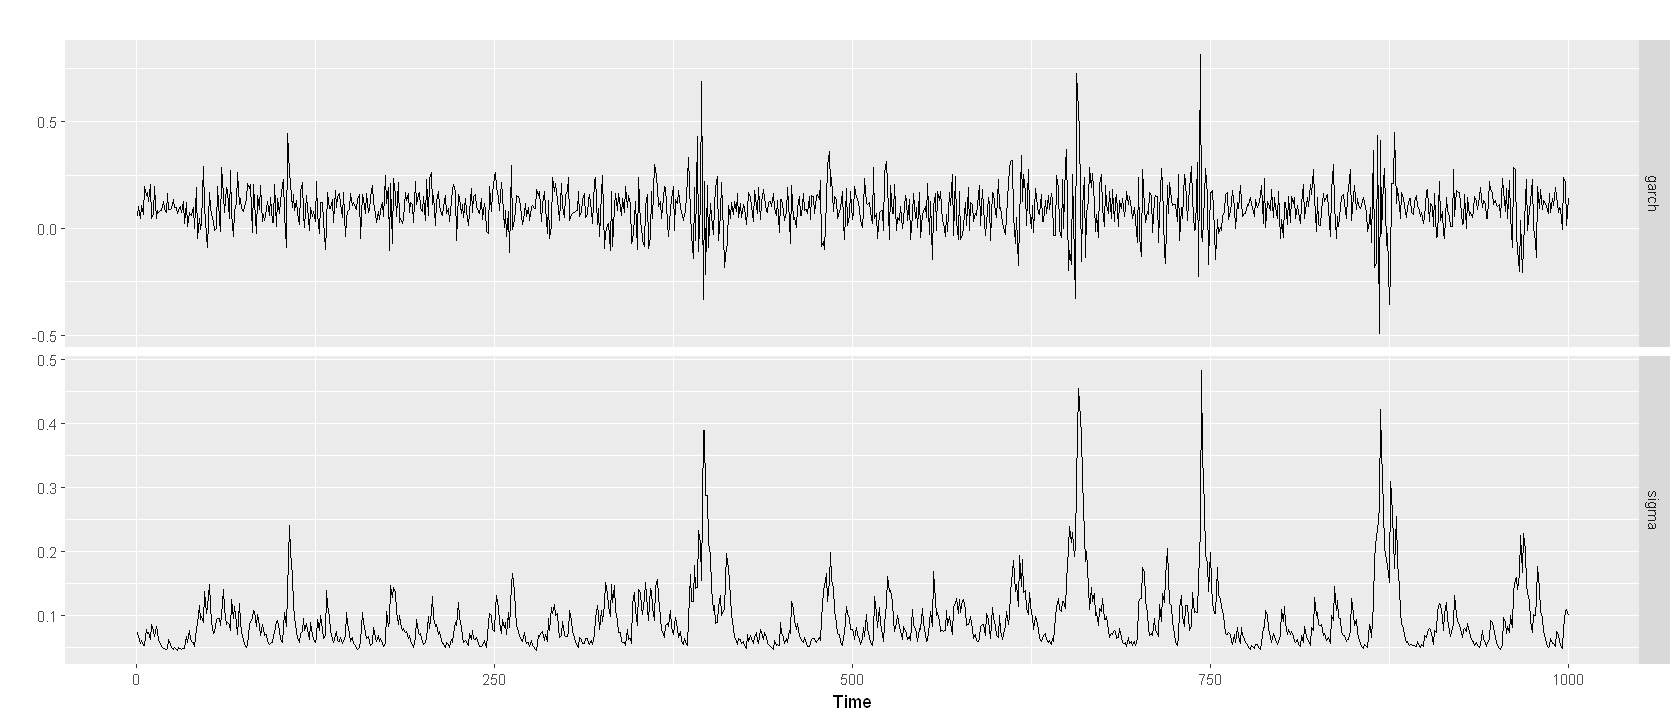

In [6]:
# 図示
autoplot(sim_garch[, -3], facets=T, ylab="")

ところどころでsigma(ボラティリティ)が大きくなり、データのブレ幅も広くなっていることが見て取れる。  
データの自己相関を確認する。

Warning message:
"`mutate_()` is deprecated as of dplyr 0.7.0.
Please use `mutate()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


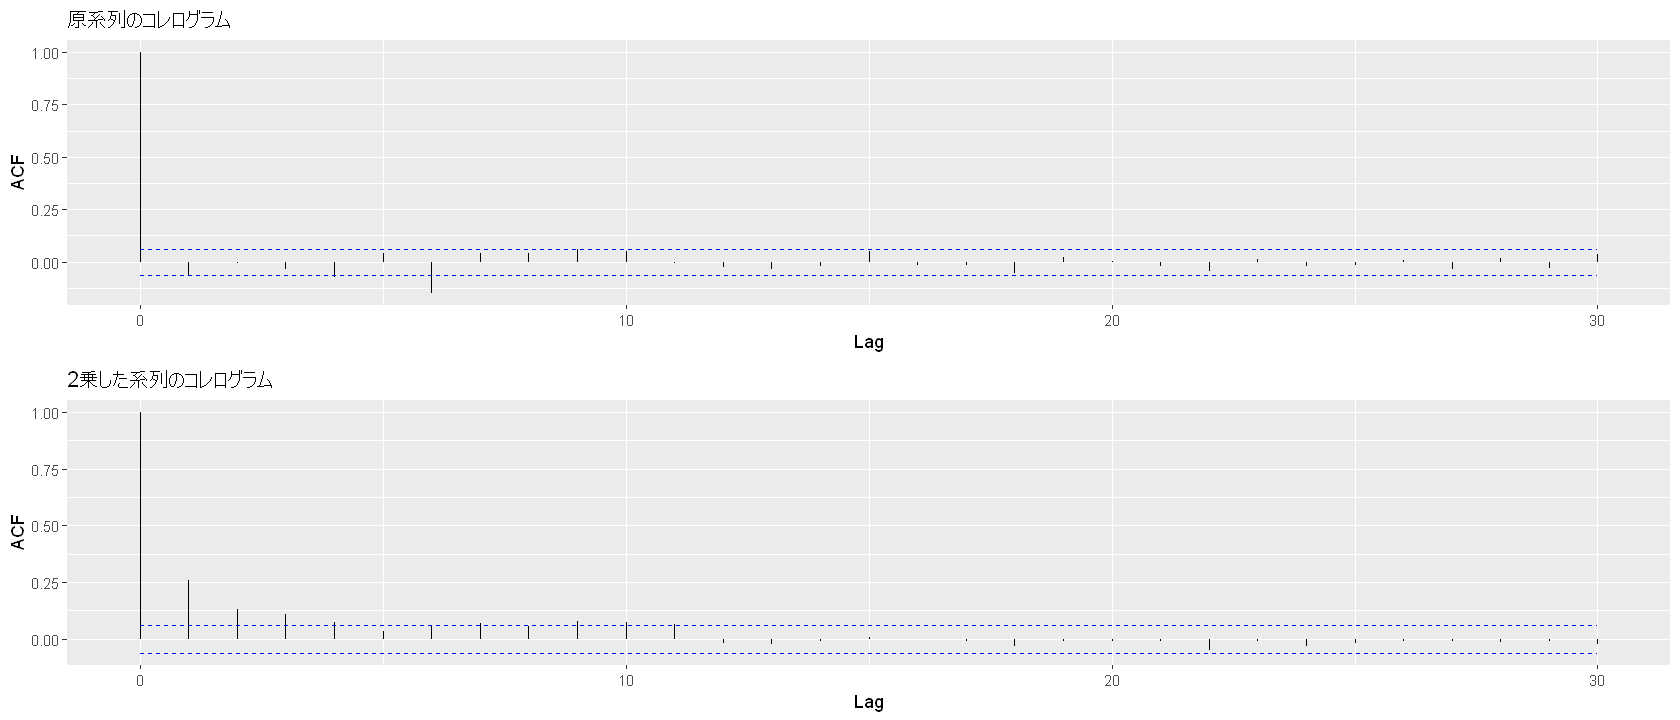

In [7]:
# 原系列のコレログラムの作成
p_acf <- autoplot(
    acf(sim_garch[, "garch"], plot=F),
    main = "原系列のコレログラム"
)

# 2乗した系列のコレログラム
p_acf_sq <- autoplot(
    acf(sim_garch[, "garch"]^2, plot=F),
    main = "2乗した系列のコレログラム"
)

# グラフを並べて表示
grid.arrange(p_acf, p_acf_sq, ncol=1)

- 原系列には自己相関がほとんど見られなかった。
- 2乗したコレログラムでは、比較的大きな自己相関があるのがわかる。
- ボラティリティが大きくなると、正か負かにブレ幅が大きくなるが、自己相関が見えなくなる。
- 2乗して政府の符号を無くしてやると、自己相関が検出できる。

## fGarchパッケージによるGARCHHモデル

モデル化を行う。fGarchパッケージのgarchFit関数を使用する。

In [8]:
mod_fGarch <- garchFit(
    formula = ~ garch(1, 1),
    data = sim_garch[, "garch"],
    include.mean = T,
    trace = F
)

Warning message:
"Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead."


In [9]:
# 計算結果
coef(mod_fGarch)

mu       omega      alpha1       beta1 
0.100912053 0.001170366 0.417202658 0.502388111

データ作成時のパラメータと近い結果になったのでうまくモデル化が推定で来ているようです。

## rugarchパッケージによるGARCHモデル

fGarchパッケージに続いてrugrachパッケージを用いてモデルを推定する。

In [10]:
# モデル構造の設定
spec_rugarch1 <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder=c(1, 1)),
    mean.model = list(armaOrder=c(0, 0), include.mean=TRUE),
    distribution.model  = 'norm'
)

# モデルの推定
mod_rugarch <- ugarchfit(
    spec = spec_rugarch1, data = sim_garch[, "garch"], solver='hybrid'
)

In [11]:
# 係数
coef(mod_rugarch)

mu      omega     alpha1      beta1 
0.10091257 0.00116921 0.41849919 0.50217532

## ARMA-GARCHモデルの作成

期待値が一定であるという前提でモデルを組んできたが、ARMAモデルのように「前の時点の値によって期待値が変わる」構造を持つことも考えられる。  

**条件付期待値のモデル** + **条件付分散のモデル** をまとめて考えてみる。

In [12]:
# シミュレーションデータの作成

# モデルのパラメタの設定
spec2 <- garchSpec(
    model = list(
        omega = 0.001, alpha = 0.5, beta = 0.4,
        mu = 0.1, ar = -0.6, ma = -0.5
    ),
    cond.dist = "norm"
)

# シミュレーションデータの作成
set.seed(0)
sim_arma_garch <- garchSim(
    spec2,
    n = n_sample,
    extended = F
)


	Ljung-Box test

data:  Residuals from ARIMA(1,0,1) with non-zero mean
Q* = 52.804, df = 7, p-value = 4.052e-09

Model df: 3.   Total lags used: 10




	Jarque Bera Test

data:  mod_arma$residuals
X-squared = 3617.7, df = 2, p-value < 2.2e-16


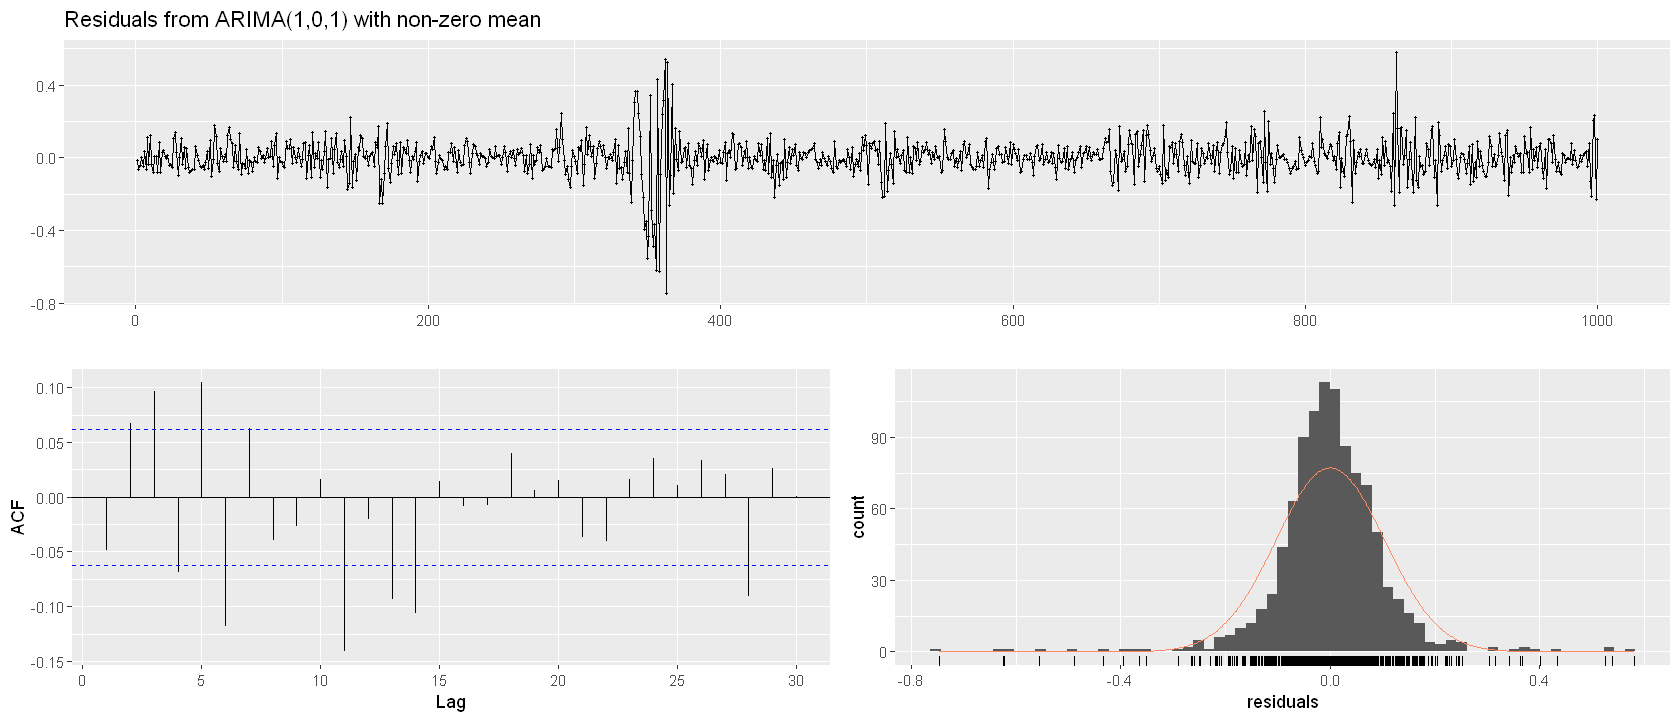

In [14]:
# ARMAモデルをシミュレーションデータから推定する
mod_arma <- Arima(sim_arma_garch, order=c(1,0,1))

# 残差のチェック
checkresiduals(mod_arma)
jarque.bera.test(mod_arma$residuals)

Ljung-Box test も jarque.bera.test もともに有意となった。  
残差は自己相関があり、正規分布にも従わない、ということになってしまった。これはダメ。

In [16]:
# ARMA+GARCHモデルを推定する
# モデル構造の設定

spec_rugarch2 <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder=c(1, 1)),
    mean.model = list(armaOrder=c(1, 1), include.mean=TRUE),
    distribution.model = "norm"
)

# モデルの推定
mod_arma_garch <- ugarchfit(
    spec = spec_rugarch2, data=sim_arma_garch, soler="hybrid"
)

# 結果
coef(mod_arma_garch)

mu           ar1           ma1         omega        alpha1 
 0.0619507448 -0.5976673455 -0.5049523792  0.0008803726  0.4498012639 
        beta1 
 0.4691972637

In [17]:
# 残差/ボラティリティ　で標準化した残差を見られる

# 標準化残差: ARMA+GARCH
resid_arma_garch <- residuals(mod_arma_garch) / sigma(mod_arma_garch)

# 標準化残差: ARMA
resid_arma <- mod_arma$residuals / sqrt(mod_arma$sigma2)

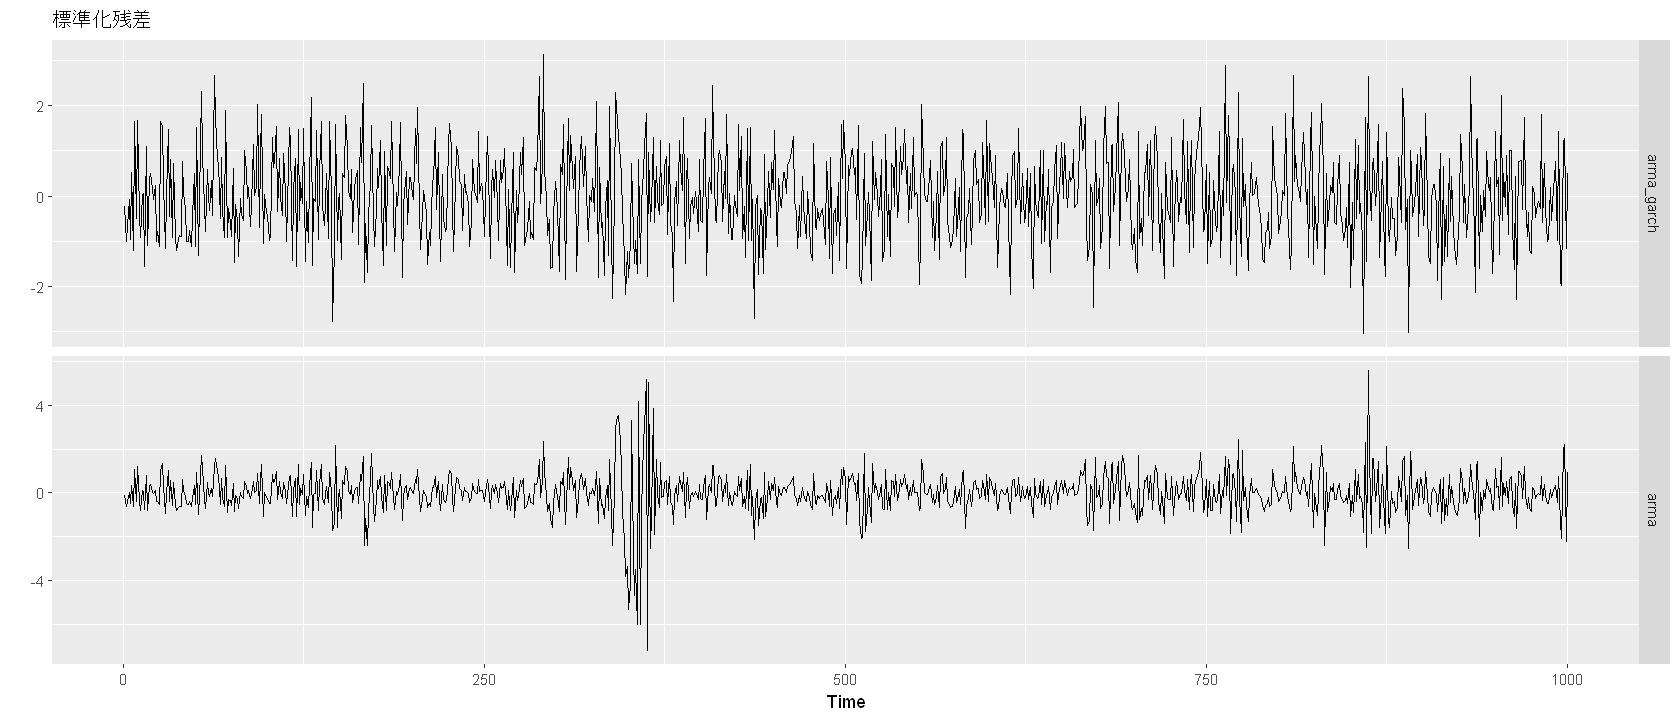

In [19]:
# データをまとめる
d <- data.frame(
    arma_garch = resid_arma_garch,
    arma = resid_arma
)

# 図示
autoplot(ts(d), facets = T, ylab="", main = "標準化残差")

- ARMA+GARCHモデルの標準化残差はデータのブレ幅がほぼ一定である
- ARMA+GARCHモデルの標準化残差はブレ幅が狭い時期と広い時期が混在している

## RによGJRモデル

GJRモデルを推定してみる。spyrealというアメリカの株式インデックスデータを対象にする。

In [20]:
data(spyreal)
head(spyreal, n=2)

                SPY_OC      SPY_RK
2002-01-02 0.005115101 0.010044750
2002-01-03 0.010151498 0.005342828

In [21]:
# GJR-GARCH(1, 1)モデルを推定する

# モデル構造の指定
spec_rugarch3 <- ugarchspec(
    variance.model = list(model="gjrGARCH", garchOrer=c(1, 1)),
    mean.model = list(armaOrder=c(1, 1)),
    distribution.model = "std"
)

# GJR GARCHの推定
mod_gjr <- ugarchfit(
    spec = spec_rugarch3, data = spyreal[, 1], solver='hybrid'
)

Warning message:
"unidentified option(s) in variance.model:
 garchOrer"


In [22]:
# 結果
coef(mod_gjr)

mu           ar1           ma1         omega        alpha1 
-4.377574e-05  5.682797e-01 -6.382338e-01  3.858231e-07  3.739245e-06 
        beta1        gamma1         shape 
 9.528466e-01  7.932203e-02  1.503937e+01

gamma1が負のノイズが入ったときにかかる影響を表すパラメタとなる。  
gamma1がプラスの値となっているので、負のノイズが加わると、正のノイズよりもボラティリティが大きくなる、つまりモデルは非対称性を考慮した方が良いと思われる。  

これを通常のGARCHモデルも作成してAICを比較してみる。

In [23]:
# 普通のGARCHモデルの作成
spec_rugarch4 <- ugarchspec(
    variance.model = list(model="sGARCH", garchOrder=c(1,1)),
    mean.model = list(armaOrder = c(1, 1)),
    distribution.model = "std"
)

# モデルの推定
mod_standard_garch <- ugarchfit(
    spec = spec_rugarch4,
    data = spyreal[, 1],
    solver = 'hybrid'
)

In [24]:
# AICの値を取り出す
infocriteria(mod_gjr)["Akaike",]
infocriteria(mod_standard_garch)["Akaike",]

[1] -6.824111

[1] -6.800208

GJRの方がわずかにAICが小さく、より適したモデルだといえる。  
そのため、非対称な影響を加味した方が良いのではないかという結果になる。  

推定されたボラティリティの変動を図示する。

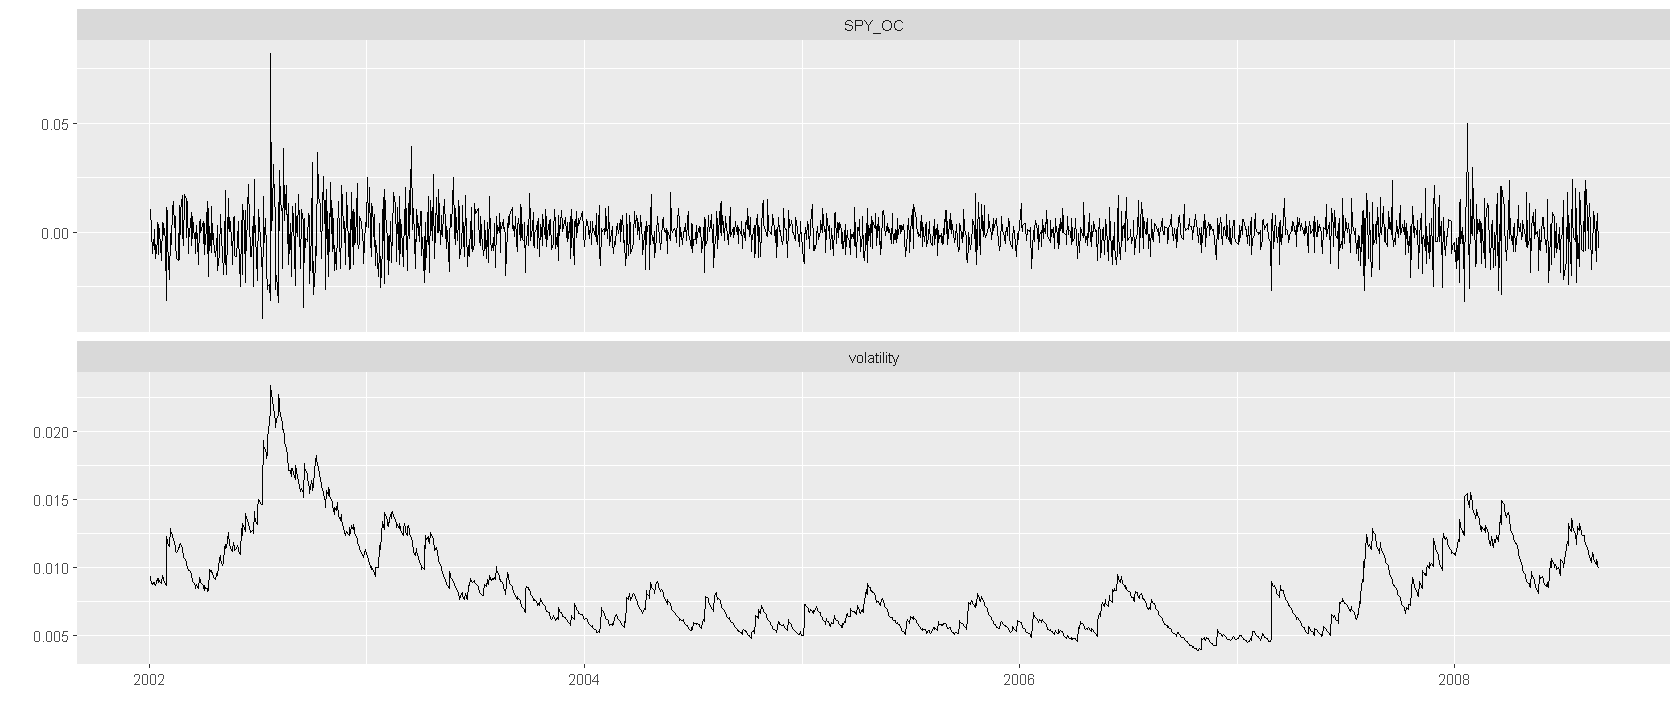

In [26]:
# データをまとめる
d_xts <- spyreal[, 1]
d_xts$volatility <- sigma(mod_gjr)

# 図示
autoplot(d_xts, facets=T, ylab="")

元のデータと予測モデルのボラティリティを見比べると、うまく表現できていることがわかる。

In [29]:
pred <- ugarchboot(mod_gjr, n.ahead=50, method="Partial")

In [30]:
pred


*-----------------------------------*
*     GARCH Bootstrap Forecast      *
*-----------------------------------*
Model : gjrGARCH
n.ahead : 50
Bootstrap method:  partial
Date (T[0]): 2008-08-29

Series (summary):
           min      q.25      mean     q.75      max forecast[analytic]
t+1  -0.028952 -0.005487 -0.000846 0.005030 0.033195           -9.3e-05
t+2  -0.033329 -0.007115 -0.000823 0.005698 0.032588           -7.2e-05
t+3  -0.029557 -0.006522 -0.000156 0.006310 0.036754           -6.0e-05
t+4  -0.031949 -0.006633 -0.000241 0.006107 0.031229           -5.3e-05
t+5  -0.034552 -0.004996  0.000467 0.007141 0.033960           -4.9e-05
t+6  -0.033271 -0.005791 -0.000205 0.005431 0.032843           -4.7e-05
t+7  -0.035185 -0.008063 -0.001730 0.004712 0.033598           -4.5e-05
t+8  -0.033017 -0.006011  0.000133 0.006302 0.034378           -4.5e-05
t+9  -0.028760 -0.007113 -0.000607 0.005668 0.029036           -4.4e-05
t+10 -0.055923 -0.006359 -0.000187 0.006137 0.029749           -4